# Online Storefront Product Categorization

Product categorization is a difficult task. Amazon has over 350 million products and 6 million sellers. All this must be fitted into 18 categories. It's not rare to find situations like the one shown in the picture bellow: a shampoo categorized in 'computers and informatics'. These situations create friction and damage users experience, leading to the loss of a potential sales.

In [8]:
# https://drive.google.com/file/d/1G3FjvmUg6iBYtD03RRtJZYaexnGvWXT-/view?usp=sharing
!gdown --id 1G3FjvmUg6iBYtD03RRtJZYaexnGvWXT-
!unzip inputs.zip

Downloading...
From: https://drive.google.com/uc?id=1G3FjvmUg6iBYtD03RRtJZYaexnGvWXT-
To: /content/inputs.zip
100% 205k/205k [00:00<00:00, 60.9MB/s]
Archive:  inputs.zip
  inflating: data.csv                
  inflating: miss-classification.PNG  


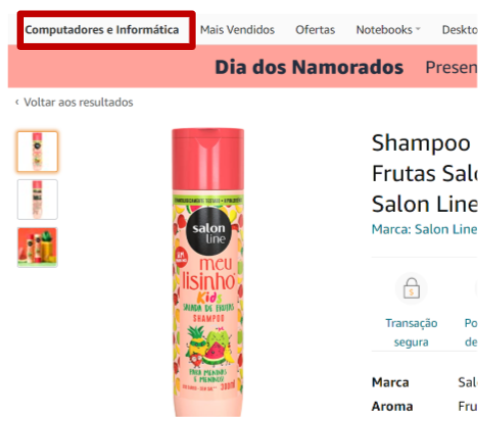

This notebook aims to analyse product description from a base scraped from amazon.com.br contaning among other things the product description and it's category. Using NLP techniques, we'll test the hypothesis that a Dimensionality reduction technique (such as PCA, MDS or TNSE) applied to word vectors can produce 2D graphics that can show differences among categories.

In [ ]:
import pandas as pd
df = pd.read_csv('/content/data.csv')

In [ ]:
dados = df.copy(deep=True)
dados.dropna(inplace=True, subset=['produto'])
print(dados.shape)
remove=['preco_inteiro','preco_decimal','rating']
dados.drop(remove, axis=1, inplace=True)
print(dados.shape)
dados.head(2)

(1216, 17)
(1216, 14)


,Unnamed: 0,Departamento,produto,prazo,frete,qtd_reviews,tag,url_produto,preco,rating_ajustado,frete_gratis,prazo_ajustado,frete_preco,frete_gratis_binario
0,0,Computadores e Informática,Notebook Lenovo Ultrafino ideapad S145 i5-1035...,NaN,NaN,NaN,"[<span class=""a-badge-text"" data-a-badge-color...",NaN,3699.0,4.4,NaN,NaN,NaN,0
1,1,Computadores e Informática,Impressora multifuncional HP DeskJet Ink Advan...,NaN,NaN,NaN,[],NaN,378.0,4.6,NaN,NaN,NaN,0


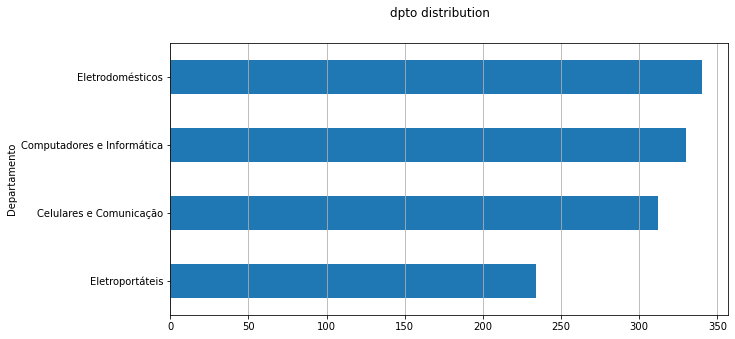

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('dpto distribution', fontsize=12)
dados['Departamento'].reset_index().groupby('Departamento').count().sort_values(by='index').plot(kind='barh', legend=False, ax=ax).grid(axis='x')
plt.show()

In [ ]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\chafu\anaconda3\python.exe -m pip install --upgrade pip' command.


# Text data preprocessing

In [ ]:
import re
import string
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PortugueseStemmer
import langdetect
import spacy

In [ ]:
# Functions to treat portuguese corpus on product description field 

nltk.download('stopwords')

# accent removal
def remover_acento(texto):
    try:
        texto = unicode(texto, 'utf-8')
    except NameError:
        pass
    texto = unicodedata.normalize('NFD', texto)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(texto)

# underscore removal
def remover_underscore(palavra):
    if palavra[0] == '_' or palavra[-1] == '_':
        return palavra.replace('_', '')
    else:
        return palavra

# NLTK stopwords list dowload
lst_stopwords_pt = nltk.corpus.stopwords.words('portuguese')
lst_stopwords_en = nltk.corpus.stopwords.words('english')

stopwords_pt = stopwords.words('portuguese')
stopwords_en = stopwords.words('english')

# adds some specif special characters to stopwords list 
stopwords_pt += list(string.punctuation)
stopwords_en += list(string.punctuation)

stopwords_pt += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", '©',
 '-', '–', '—', '_',"/", "pra", "B","aa", "ac" ]
stopwords_en += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", '©',
 '-', '–', '—', '_',"/", "pra", "B","aa", "ac" ]

stopwords_pt = set(stopwords_pt)
stopwords_en = set(stopwords_en)


# stop words removal
def remover_stopwords(texto, lista=False):
    palavras = re.findall(r'\b[A-zÀ-úü]+\b', texto.lower())
    sem_stopwords = [p for p in palavras if p not in stopwords_pt]
    if lista:
        return sem_stopwords
    else:
        return ' '.join(sem_stopwords)

# Stemming function
def stemizar(texto_original):
    palavras_importantes = remover_stopwords(texto_original, lista=True)
    
    stemizador = PortugueseStemmer()
    palavras = []

    for p in palavras_importantes:
        novo_p = remover_underscore(remover_acento(p))
        palavras.append(stemizador.stem(novo_p))
    return ' '.join(palavras)

# loads spaCy models
nlp_en = spacy.load('en_core_web_sm')
nlp_pt = spacy.load('pt_core_news_lg')

# Lemmatization in portuguese
def lematizar_pt(texto_original):
    palavras_importantes = remover_stopwords(texto_original, lista=True)
    
    texto_importante = ' '.join(palavras_importantes)
    texto_importante = remover_underscore(remover_acento(texto_importante))
    
    doc_pt = nlp_pt(texto_importante)
    doc_pt_lematizado = [token.lemma_ if token.pos_ == 'VERB' else str(token) for token in doc_pt]
    ret = ' '.join(doc_pt_lematizado)
    return (ret)

# Lemmatization in english
def lematizar_en(texto_original):
    palavras_importantes = remover_stopwords(texto_original, lista=True)
    
    texto_importante = ' '.join(palavras_importantes)
    texto_importante = remover_underscore(remover_acento(texto_importante))
    
    doc_en = nlp_en(texto_importante)
    doc_en_lematizado = [token.lemma_ if token.pos_ == 'VERB' else str(token) for token in doc_en]
    ret = ' '.join(doc_en_lematizado)
    return (ret)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chafu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# language detection
dados['language'] = dados['produto'].apply(lambda x: langdetect.detect(x) if x.strip() != '' else '')
dados.head(2)

,Unnamed: 0,Departamento,produto,prazo,frete,qtd_reviews,tag,url_produto,preco,rating_ajustado,frete_gratis,prazo_ajustado,frete_preco,frete_gratis_binario,language
0,0,Computadores e Informática,Notebook Lenovo Ultrafino ideapad S145 i5-1035...,NaN,NaN,NaN,"[<span class=""a-badge-text"" data-a-badge-color...",NaN,3699.0,4.4,NaN,NaN,NaN,0,en
1,1,Computadores e Informática,Impressora multifuncional HP DeskJet Ink Advan...,NaN,NaN,NaN,[],NaN,378.0,4.6,NaN,NaN,NaN,0,en


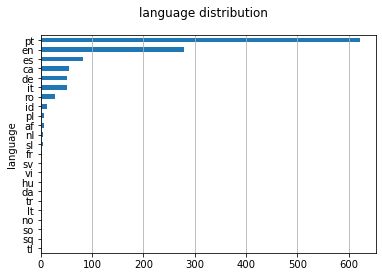

In [ ]:
# language distribution plot
fig, ax = plt.subplots()
fig.suptitle('language distribution', fontsize=12)
dados['language'].reset_index().groupby('language').count().sort_values(by=
'index').plot(kind='barh', legend=False, ax=ax).grid(axis='x')
plt.show()

In [ ]:
# creates two new variables: one using PT leammatization pipeline and the other using EN lemmatization pipeline
dados['produto_lem_pt'] = dados.produto.astype(str).apply(lematizar_pt)
dados['produto_lem_en'] = dados.produto.astype(str).apply(lematizar_en)

In [ ]:
# removes stop words
dados['produto_no_stopwords'] = dados.produto.astype(str).apply(remover_stopwords)

In [ ]:
print(dados.shape)
dados.columns

(1216, 18)


Index(['Unnamed: 0', 'Departamento', 'produto', 'prazo', 'frete',
       'qtd_reviews', 'tag', 'url_produto', 'preco', 'rating_ajustado',
       'frete_gratis', 'prazo_ajustado', 'frete_preco', 'frete_gratis_binario',
       'language', 'produto_lem_pt', 'produto_lem_en', 'produto_no_stopwords'],
      dtype='object')

In [ ]:
# index adjustment

data = dados.copy(deep=True)
data.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
data['c'] = 0
for i in range(data.shape[0]):
    data.iloc[i,-1] = i

In [ ]:
data.iloc[1215,-1]

1215

In [ ]:
data.set_index('c', drop=True, append=False, inplace=True, verify_integrity=True)

In [ ]:
data.tail(2)

,Departamento,produto,prazo,frete,qtd_reviews,tag,url_produto,preco,rating_ajustado,frete_gratis,prazo_ajustado,frete_preco,frete_gratis_binario,language,produto_lem_pt,produto_lem_en,produto_no_stopwords
c,,,,,,,,,,,,,,,,,
1214,Celulares e Comunicação,Carregador Rápido Samsung sem Fio Pad II 2019 ...,NaN,"Receba atéSábado, 29 de maiOpção de frete GRÁT...",131.0,[],/Carregador-R%C3%A1pido-Samsung-Preto-Original...,189.0,4.8,frete grátis,7.0,0.00,1,pt,carregador rapido samsung fio pad ii preto ori...,carregador rapido samsung fio pad ii preto ori...,carregador rápido samsung fio pad ii preto ori...
1215,Celulares e Comunicação,"Smartwatch Amazfit GTS 2, Relógio Inteligente,...",NaN,"R$ 31,92 de frete",861.0,[],/Smartwatch-Amazfit-Inteligente-telef%C3%B4nic...,1149.0,4.7,NaN,NaN,31.92,0,pt,smartwatch amazfit gts relogio inteligente dis...,smartwatch amazfit gts relogio inteligente dis...,smartwatch amazfit gts relógio inteligente dis...


## Word Clouds

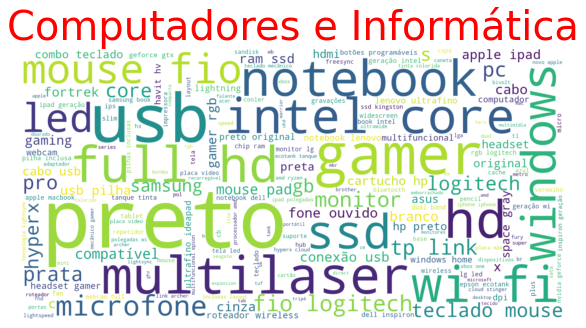

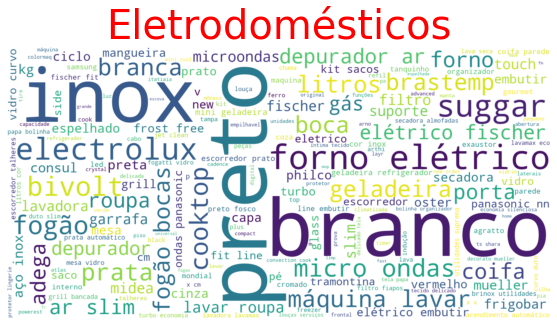

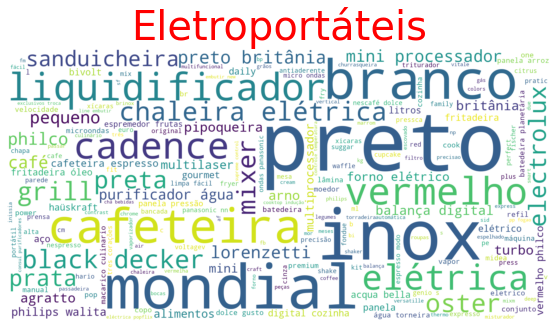

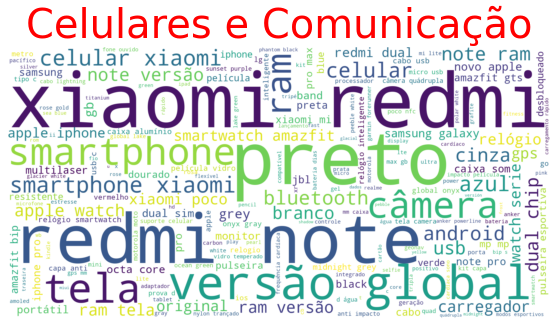

In [ ]:
from wordcloud import WordCloud

dptos = dados['Departamento'].unique()

for i, dpt in enumerate(dptos):
    word_lists = dados[dados['Departamento']==dpt].produto_no_stopwords.values
    unique_str  = ' '.join(word_lists)
    
    wc = WordCloud(min_font_size=10, 
                   max_font_size=300, 
                   background_color='white', 
                   mode="RGB",
                   width=2000, 
                   height=1000,
                   normalize_plurals= True).generate(unique_str)    
    
    plt.subplots(figsize=(10,5))
    plt.title(dpt, fontsize=40, color="red")
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Word Embedding

Word embedding is a technique that finds numerical vectors representations for texts. Such vector representations are obtained through the method vectorize from spaCy package. This method applies pre-trained models known as word2vec and transforms text into numerical vectors so that they correspond to how the words are used and their meaning in the context to which they belong (this study used the en-core-web-lg model). Words used in similar contexts produce similar vectors, i.e., geometrically close.

For example, the subtraction of the vector representation for the word man from the vector of the word woman results in a new vector which, if added to the vector for the word king, creates a new vector that is close to the vector for queen.

These vector representations can be used as features in Machine Learning models, providing great advances for the application of NLP. These models can be incorporated into technologies that are part of people's daily lives, such as: devices and applications that suggest/predict the next words typed by a user, music and video streaming apps that provide recommendations, etc.

In [ ]:
import numpy as np
with nlp_pt.disable_pipes():
    doc_vectors = np.array([nlp_pt(text).vector for text in data.produto_lem_pt])
doc_vectors.shape

(1216, 300)

In [ ]:
# 300 dimension vectors for each description obtained by word embedding model
doc_vectors

array([[ 0.6753118 , -0.49696273, -0.8930136 , ..., -0.69806445,
        -0.22367391,  0.43276453],
       [-2.2797136 , -1.4618123 , -3.5843003 , ...,  0.93561244,
        -1.2405763 ,  0.33667225],
       [-1.7967174 , -1.8340284 , -1.8259262 , ..., -0.53252184,
        -1.0439391 ,  0.3790518 ],
       ...,
       [-1.0134667 , -1.5964665 , -1.4464735 , ...,  0.82367116,
        -2.819415  , -0.33381   ],
       [-1.1960886 , -1.6462238 , -0.7157617 , ..., -1.8072951 ,
        -0.6898888 ,  0.71789753],
       [ 0.0616596 , -0.7740692 , -1.039957  , ..., -1.2948781 ,
        -1.0411536 ,  0.22480664]], dtype=float32)

## Factor Analysis for dimension reduction

The idea now is to see if these word vectors that have 300 dimensions can be represented by only 2 dimensions obtained by dimension reduction methods and then displayed on 2D plots in order to check if different product categories have different representations

In [ ]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
doc_vectors_pca = pca.fit_transform(doc_vectors)
doc_vectors_pca.shape

(1216, 2)

In [ ]:
# Put 2 main components into a dataframe
dados_pca = pd.DataFrame(doc_vectors_pca, columns=['c1','c2'])
Dpto = data.loc[:,['Departamento']]
data_pca = pd.concat([dados_pca, Dpto], axis=1)

<AxesSubplot:xlabel='c1', ylabel='c2'>

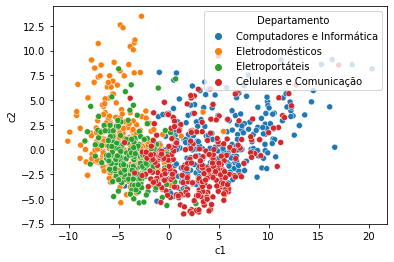

In [ ]:
import seaborn as sns
sns.scatterplot(x=data_pca.iloc[:,0], y=data_pca.iloc[:,1], hue=data_pca['Departamento'])

The four categories descriptions 2D representations obtained by PCA are mixed. Perhaps this is due to poor classification and description made by sellers.

In [ ]:
# TSNE
from sklearn.manifold import TSNE
doc_vectors_tsne = pd.DataFrame(TSNE(n_components=2, perplexity=30).fit_transform(doc_vectors))

In [ ]:
data_tsne = pd.concat([doc_vectors_tsne, Dpto], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

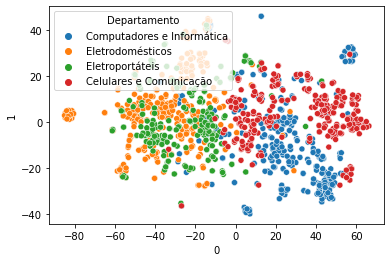

In [ ]:
sns.scatterplot(x=data_tsne.iloc[:,0], y=data_tsne.iloc[:,1], hue=data_tsne['Departamento'])

Results obtained from t-Distributed Stochastic Neighbor Embedding (TSNE) are similar to the previous results from PCA. Observe that the mixture of categories and the macro groups they form ar similar.

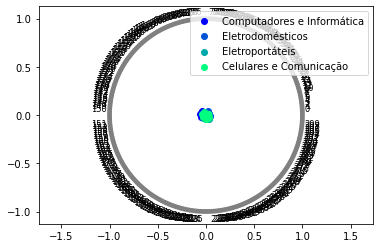

In [ ]:
# Radviz
doc_vectors_dp = pd.concat([pd.DataFrame(doc_vectors), Dpto], axis=1)
from pandas.plotting import radviz
radviz(doc_vectors_dp, 'Departamento', colormap='winter');

RadViz lead to nowhere... too many dimensions to represent.

Wordclouds above showed that some color names were frequent among description and they aren't good descriminators among our categories (all the products kind have the same white, blackl, silver color, right?) Let's try to remove color names from description and check 2D representations again

In [ ]:
lst_stopwords_pt = nltk.corpus.stopwords.words('portuguese')

stopwords_pt = stopwords.words('portuguese')

stopwords_pt += list(string.punctuation)

stopwords_pt += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", '©',
 '-', '–', '—', '_',"/", "pra", "B","aa", "ac" ]

stopwords_pt += ['preto', 'preta', 'black',
 'branco', 'branca', 'white',
 'prata', 'silver',
 'cinza', 'grey',
 'vermelho', 'vermelha', 'red',
 'dourado', 'dourada', 'golden',
 'verde', 'green',
 'amarelo', 'amarela', 'yellow',
 'laranja', 'laranjado', 'orange'
]

stopwords_pt = set(stopwords_pt)

In [ ]:
data['produto_lem_pt2'] = data.produto.astype(str).apply(lematizar_pt)

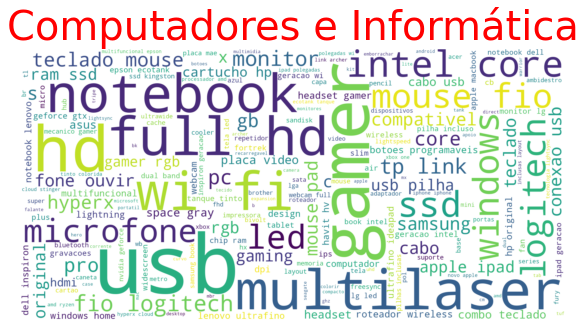

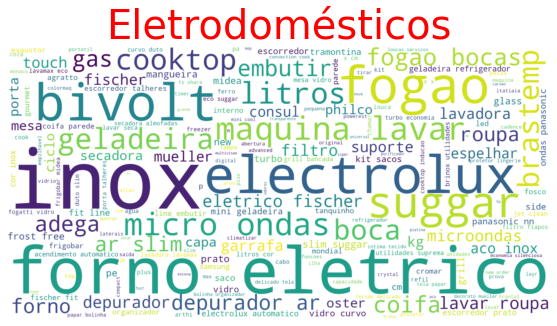

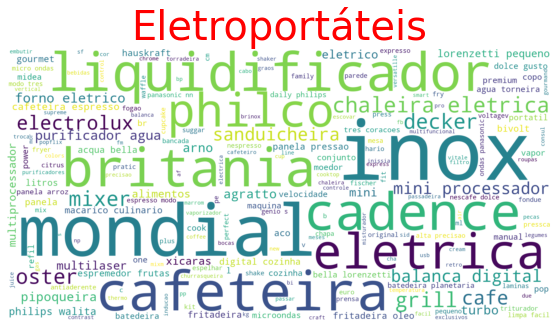

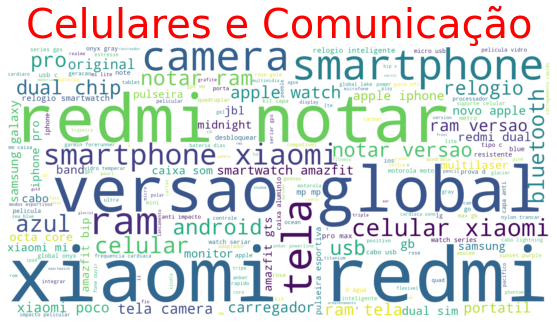

In [ ]:
dptos = dados['Departamento'].unique()

for i, dpt in enumerate(dptos):
    word_lists = data[data['Departamento']==dpt].produto_lem_pt2.values
    unique_str  = ' '.join(word_lists)
    
    wc = WordCloud(min_font_size=10, 
                   max_font_size=300, 
                   background_color='white', 
                   mode="RGB",
                   width=2000, 
                   height=1000,
                   normalize_plurals= True).generate(unique_str)    
    
    plt.subplots(figsize=(10,5))
    plt.title(dpt, fontsize=40, color="red")
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
with nlp_pt.disable_pipes():
    doc_vectors = np.array([nlp_pt(text).vector for text in data.produto_lem_pt2])
doc_vectors.shape

(1216, 300)

In [ ]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
doc_vectors_pca = pca.fit_transform(doc_vectors)
doc_vectors_pca.shape

(1216, 2)

In [ ]:
dados_pca = pd.DataFrame(doc_vectors_pca, columns=['c1','c2'])
Dpto = data.loc[:,['Departamento']]
data_pca = pd.concat([dados_pca, Dpto], axis=1)

<AxesSubplot:xlabel='c1', ylabel='c2'>

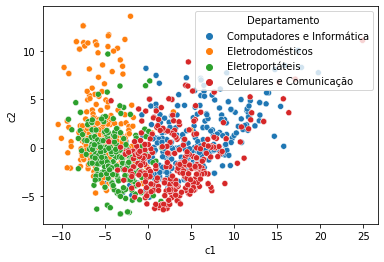

In [ ]:
import seaborn as sns
sns.scatterplot(x=data_pca.iloc[:,0], y=data_pca.iloc[:,1], hue=data_pca['Departamento'])

Removing color names didn't impact on the descriptions representations in terms of how they segregate or group. But, if we apply some color grouping, we can see some pattern forming...

<AxesSubplot:xlabel='c1', ylabel='c2'>

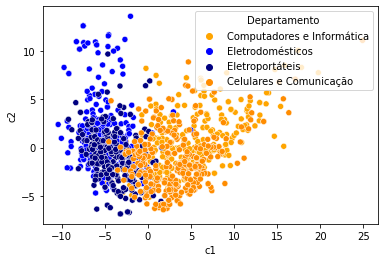

In [ ]:
sns.scatterplot(x=data_pca.iloc[:,0], y=data_pca.iloc[:,1], hue=data_pca['Departamento'],
                palette = ['orange', 'blue', 'navy', 'darkorange'])

<AxesSubplot:xlabel='0', ylabel='1'>

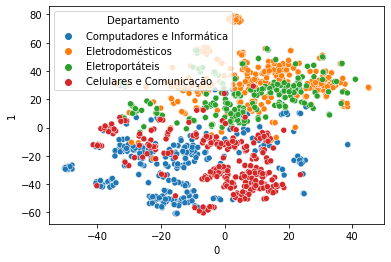

In [ ]:
# TSNE
from sklearn.manifold import TSNE
doc_vectors_tsne = pd.DataFrame(TSNE(n_components=2, perplexity=30).fit_transform(doc_vectors))
data_tsne = pd.concat([doc_vectors_tsne, Dpto], axis=1)
sns.scatterplot(x=data_tsne.iloc[:,0], y=data_tsne.iloc[:,1], hue=data_tsne['Departamento'])

<AxesSubplot:xlabel='0', ylabel='1'>

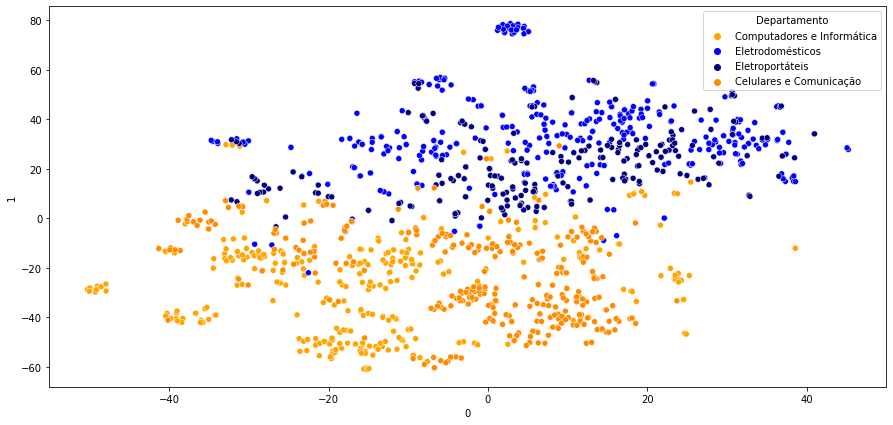

In [ ]:
plt.subplots(figsize=(15,7))
sns.scatterplot(x=data_tsne.iloc[:,0], y=data_tsne.iloc[:,1], hue=data_tsne['Departamento'],
                palette = ['orange', 'blue', 'navy', 'darkorange'])

Conclusion: when we use PCA and TSNE we get a fairly distinction not between the categories themselves, but between 'groups' of categories, i.e., if we consider 'Computadores e Informática' and 'Celulares e Comunicação' as a category group and 'Eletrodomésticos' and 'Eletroportáteis' as another, we can see that most of the products fall on different sides on the plot above. This group segmentation seens reasonable enough and this hypothesis could be validated if we would gather more data with more heterogeneous categories.